In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.utils import shuffle
import cv2

import tensorflow as tf 
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [41]:
data_path = "./cassava-leaf-disease-classification/"
train_csv_data_path = data_path+"train.csv"
label_json_data_path = data_path+"label_num_to_disease_map.json"
images_dir_data_path = data_path+"train_images"

In [42]:
train_csv = pd.read_csv(train_csv_data_path)
train_csv['label'] = train_csv['label'].astype('str')
label_class = pd.read_json(label_json_data_path, orient='index')
label_class = label_class.values.flatten().tolist()

### Undersampling 

In [43]:
train_data_label_3 = train_csv[train_csv["label"]=='3']
train_data_label_3 = shuffle(train_data_label_3)
train_data_label_3= train_data_label_3[:3000]

train_data_label_not_3 = train_csv[train_csv["label"]!='3']

train_csv = pd.concat([train_data_label_3, train_data_label_not_3], ignore_index=True)
print("Label names :")
for i, label in enumerate(label_class):
    print(f" {i}. {label}")

Label names :
 0. Cassava Bacterial Blight (CBB)
 1. Cassava Brown Streak Disease (CBSD)
 2. Cassava Green Mottle (CGM)
 3. Cassava Mosaic Disease (CMD)
 4. Healthy


In [44]:
d = {}
for i, label in enumerate(label_class):
    d[str(i)] = label

df_train = train_csv.groupby('label')['image_id'].count().reset_index()
df_train.replace(d)

,label,image_id
0,Cassava Bacterial Blight (CBB),1087
1,Cassava Brown Streak Disease (CBSD),2189
2,Cassava Green Mottle (CGM),2386
3,Cassava Mosaic Disease (CMD),3000
4,Healthy,2577


# Generadores

In [45]:
BATCH_SIZE = 18
IMG_SIZE = 320

In [46]:
# Data augmentation
train_gen = ImageDataGenerator(
                                rotation_range=360,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                brightness_range=[0.6,1],
                                shear_range=25,
                                zoom_range=0.1,
                                channel_shift_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1/255,
                                validation_split=0.15
                               )
                                    
    
valid_gen = ImageDataGenerator(rescale=1/255,
                               validation_split = 0.15
                              )

In [47]:
train_generator = train_gen.flow_from_dataframe(
                            dataframe=train_csv,
                            directory = images_dir_data_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            subset = "training"
)

valid_generator = valid_gen.flow_from_dataframe(
                            dataframe=train_csv,
                            directory = images_dir_data_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            subset = "validation"
)

Found 9554 validated image filenames belonging to 5 classes.
Found 1685 validated image filenames belonging to 5 classes.


C:\Users\adoncel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


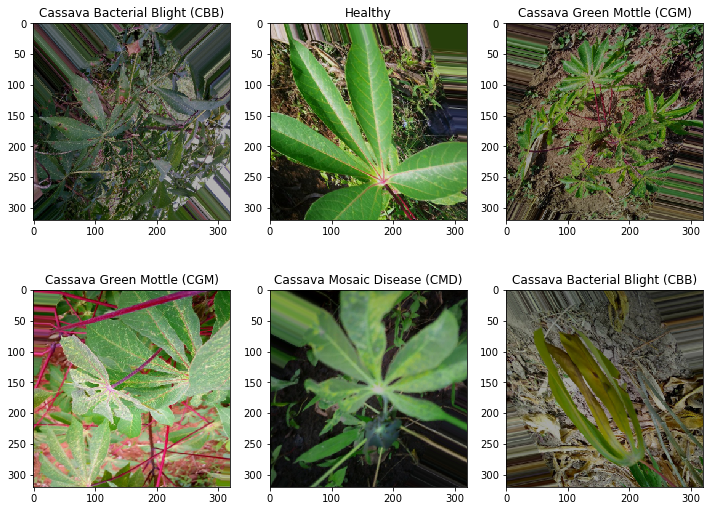

In [48]:
batch = next(train_generator)
images = batch[0]
labels = batch[1]

plt.figure(figsize=(12,9))
for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(2,3, i%6 +1)
    plt.imshow(img)
    plt.title(label_class[np.argmax(label)])
    
    if i==15:
        break

# CNN Neural Network

In [49]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from keras.utils import to_categorical
from keras import regularizers, optimizers

In [50]:
inp = Input(shape=[IMG_SIZE,IMG_SIZE,3])
x = Conv2D(64, (7, 7), activation='relu')(inp)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (5, 5), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)


# Fully-Connected Layers
x = Flatten()(x) 
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
output3 = Dense(5, activation = 'sigmoid')(x)


#model = Model(inp,[output1,output2,output3])
model = Model(inp,output3)
model.compile(optimizers.RMSprop(lr = 0.0001, decay = 1e-6),
              loss = ["binary_crossentropy"],
              metrics = ["accuracy"])

In [51]:
N_EPOCHS = 5
model_history = model.fit(train_generator, 
                         epochs=N_EPOCHS, 
                         validation_data=valid_generator,
                         validation_steps=10,
                         steps_per_epoch=10)

Epoch 1/5
10/10 [==============================] - 64s 6s/step - loss: 0.5718 - accuracy: 0.7367 - val_loss: 0.7473 - val_accuracy: 0.8000
Epoch 2/5
10/10 [==============================] - 61s 6s/step - loss: 0.5139 - accuracy: 0.7911 - val_loss: 0.6483 - val_accuracy: 0.8000
Epoch 3/5
10/10 [==============================] - 61s 6s/step - loss: 0.5180 - accuracy: 0.7944 - val_loss: 0.6856 - val_accuracy: 0.8000
Epoch 4/5
10/10 [==============================] - 63s 6s/step - loss: 0.5128 - accuracy: 0.7956 - val_loss: 0.6509 - val_accuracy: 0.8000
Epoch 5/5
10/10 [==============================] - 64s 6s/step - loss: 0.5211 - accuracy: 0.7989 - val_loss: 0.6092 - val_accuracy: 0.8000


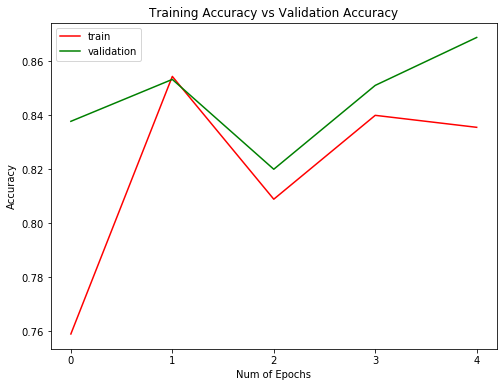

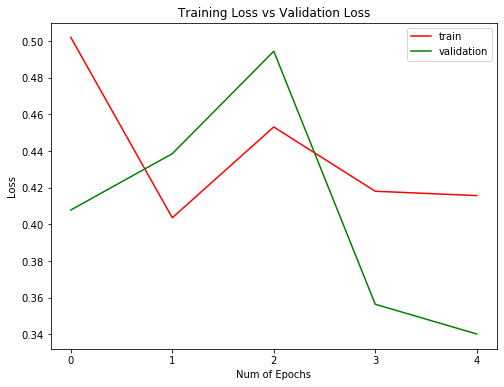

In [40]:
plt.figure(0)  
plt.plot(model_history.history['accuracy'],'r')  
plt.plot(model_history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, N_EPOCHS, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(model_history.history['loss'],'r')  
plt.plot(model_history.history['val_loss'],'g')  
plt.xticks(np.arange(0, N_EPOCHS, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  